# Fater RCNN tutorial 

## 초기 설정

In [1]:
from typing import List, Tuple, Dict, Optional

import os 
import torch 
import torchvision
from torch import nn, Tensor
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np 

from PIL import Image
from matplotlib import pyplot as plt 
from matplotlib import patches

## 데이터 전처리

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # 모든 이미지 파일들을 읽고, 정렬하여
        # 이미지와 분할 마스크 정렬을 확인합니다
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # 이미지와 마스크를 읽어옵니다
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # 분할 마스크는 RGB로 변환하지 않음을 유의하세요
        # 왜냐하면 각 색상은 다른 인스턴스에 해당하며, 0은 배경에 해당합니다
        mask = Image.open(mask_path)
        # numpy 배열을 PIL 이미지로 변환합니다
        mask = np.array(mask)
        # 인스턴스들은 다른 색들로 인코딩 되어 있습니다.
        obj_ids = np.unique(mask)
        # 첫번째 id 는 배경이라 제거합니다
        obj_ids = obj_ids[1:]

        # 컬러 인코딩된 마스크를 바이너리 마스크 세트로 나눕니다
        masks = mask == obj_ids[:, None, None]

        # 각 마스크의 바운딩 박스 좌표를 얻습니다
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # 모든 것을 torch.Tensor 타입으로 변환합니다
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # 객체 종류는 한 종류만 존재합니다(역자주: 예제에서는 사람만이 대상입니다)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
# object detection을 위한 함수들
# 출처: https://github.com/pytorch/vision/blob/main/references/detection/transforms.py

class ToTensor(nn.Module):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = transforms.functional.pil_to_tensor(image)
        image = transforms.functional.convert_image_dtype(image)
        return image, target

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

def get_transform():
    tfs = []
    tfs.append(ToTensor())
    return Compose(tfs)

def collate_fn(batch):
    return tuple(zip(*batch))


In [4]:
# 데이터 로드
# 출처: https://www.cis.upenn.edu/~jshi/ped_html/

dataset = PennFudanDataset('PennFudanPed', transforms=get_transform())
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-10])
dataset_test = torch.utils.data.Subset(dataset, indices[-10:])

In [5]:
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

## 모델 학습 및 평가

In [6]:
# COCO로 미리 학습된 모델 읽기
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 분류기를 새로운 것으로 교체하는데, num_classes는 사용자가 정의합니다
num_classes = 2  # 1 클래스(사람) + 배경
# 분류기에서 사용할 입력 특징의 차원 정보를 얻습니다
in_features = model.roi_heads.box_predictor.cls_score.in_features
# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체합니다
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [7]:
# 장치 설정
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.005, 
                            momentum=0.9, 
                            weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                               step_size=3, 
                                               gamma=0.1)

In [9]:
# 학습을 위한 함수 
# 출처: https://github.com/pytorch/vision/blob/main/references/detection/utils.py

import torch.distributed as dist

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

In [10]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()

    for i, (images, targets) in enumerate(data_loader, 0):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        lr_scheduler.step()
        if i % (len(data_loader) // 10) == 0 or i == len(data_loader)-1:
            print(f'Epoch {epoch+1}, {i+1}/{len(data_loader)} - loss: {loss_value}')


/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 1, 1/80 - loss: 1.3070685863494873
Epoch 1, 9/80 - loss: 0.39609891176223755
Epoch 1, 17/80 - loss: 0.4491555392742157
Epoch 1, 25/80 - loss: 0.31185781955718994
Epoch 1, 33/80 - loss: 0.38666123151779175
Epoch 1, 41/80 - loss: 0.5484731197357178
Epoch 1, 49/80 - loss: 0.43766653537750244
Epoch 1, 57/80 - loss: 0.5537039637565613
Epoch 1, 65/80 - loss: 0.6213547587394714
Epoch 1, 73/80 - loss: 0.47256502509117126
Epoch 1, 80/80 - loss: 0.6668379306793213


In [18]:
model.cpu() # GPU 메모리가 부족해서 test에서 바꿈 
model.eval()
test_images = []
predictions = []

for i, (images, targets) in enumerate(data_loader_test):
    if i > 2:
        break
    pred = model(images)
    test_images.append(images[0])
    predictions.append({k: v for k, v in pred[0].items()})

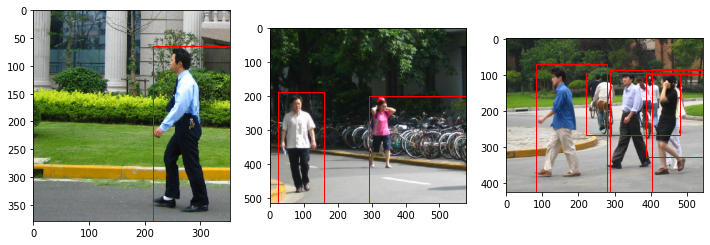

In [21]:
# 모델의 예측 결과를 표시

threshold = 0.15

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i in range(len(predictions)):
    ax[i].imshow(np.transpose(test_images[i], (1, 2, 0)))
    for j in range(len(predictions[i]['labels'])):
        if predictions[i]['scores'][j] > threshold:
            rect = patches.Rectangle(predictions[i]['boxes'][j][:2].detach().numpy(),  
                                     predictions[i]['boxes'][j][2].detach().numpy(), 
                                     predictions[i]['boxes'][j][3].detach().numpy(), 
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax[i].add_patch(rect)

plt.show()

- 시간적 요인으로 학습 epochs를 매우 적게 함
- 그럼에도 어느정도 사람(object)를 탐지하는 모습을 보임
- GPU 사용 시 빠르다고 느껴짐 (다른 모델을 사용해 보지 않음)